Processing file from URL: https://raw.githubusercontent.com/Silverstar2793/DM_Nifty/main/Nifty_50_concatenated.csv
Saved stock prices plot.
Epoch 1/10
735/735 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step
Epoch 1 - Accuracy: 0.9851, F1 Score: 0.9664, Precision: 0.9978
3307/3307 ━━━━━━━━━━━━━━━━━━━━ 337s 101ms/step - loss: 2.1869e-04 - val_loss: 8.2645e-06
Epoch 2/10
735/735 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step
Epoch 2 - Accuracy: 0.9966, F1 Score: 0.9925, Precision: 0.9953
3307/3307 ━━━━━━━━━━━━━━━━━━━━ 333s 101ms/step - loss: 1.8330e-05 - val_loss: 3.4738e-06
Epoch 3/10
735/735 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step
Epoch 3 - Accuracy: 0.9963, F1 Score: 0.9918, Precision: 0.9963
3307/3307 ━━━━━━━━━━━━━━━━━━━━ 383s 101ms/step - loss: 2.2049e-05 - val_loss: 3.5010e-06
Epoch 4/10
735/735 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step
Epoch 4 - Accuracy: 0.9941, F1 Score: 0.9872, Precision: 0.9773
3307/3307 ━━━━━━━━━━━━━━━━━━━━ 388s 103ms/step - loss: 1.2389e-05 - val_loss: 3.7242e-06
Epoch 5/10
735/735 ━━━━━━━━━━━━━

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 60, 50)              │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 50)                  │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 73,655 (287.72 KB)

 Trainable params: 24,551 (95.90 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 49,104 (191.82 KB)

Total Accuracy: 0.9938, Total F1 Score: 0.9862, Total Precision: 0.9930


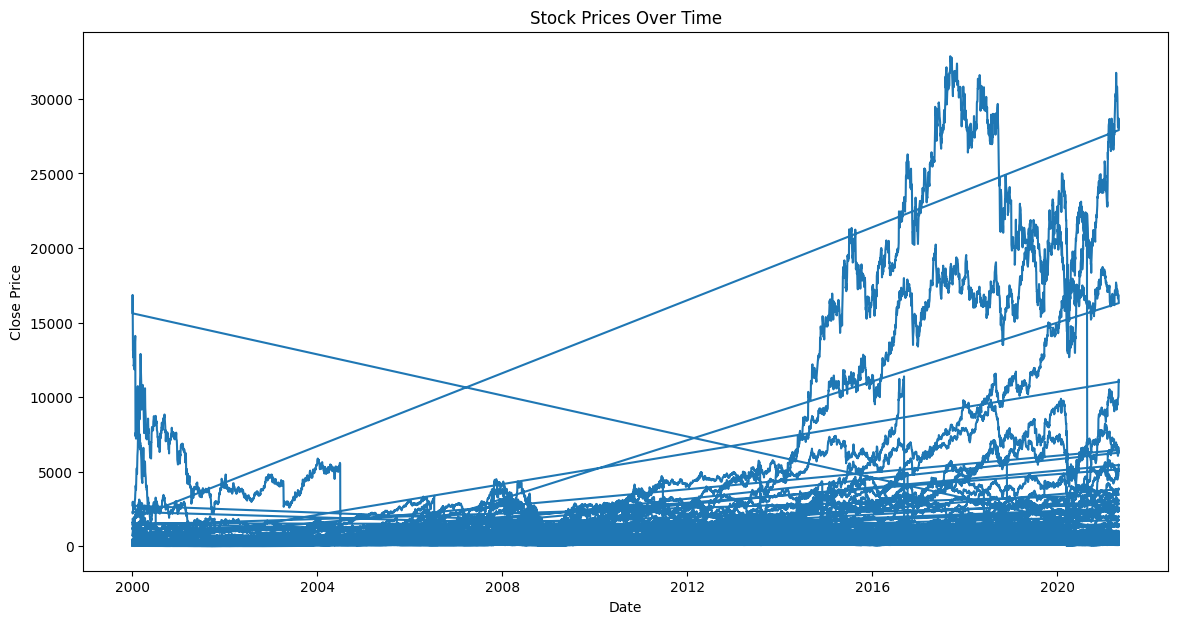

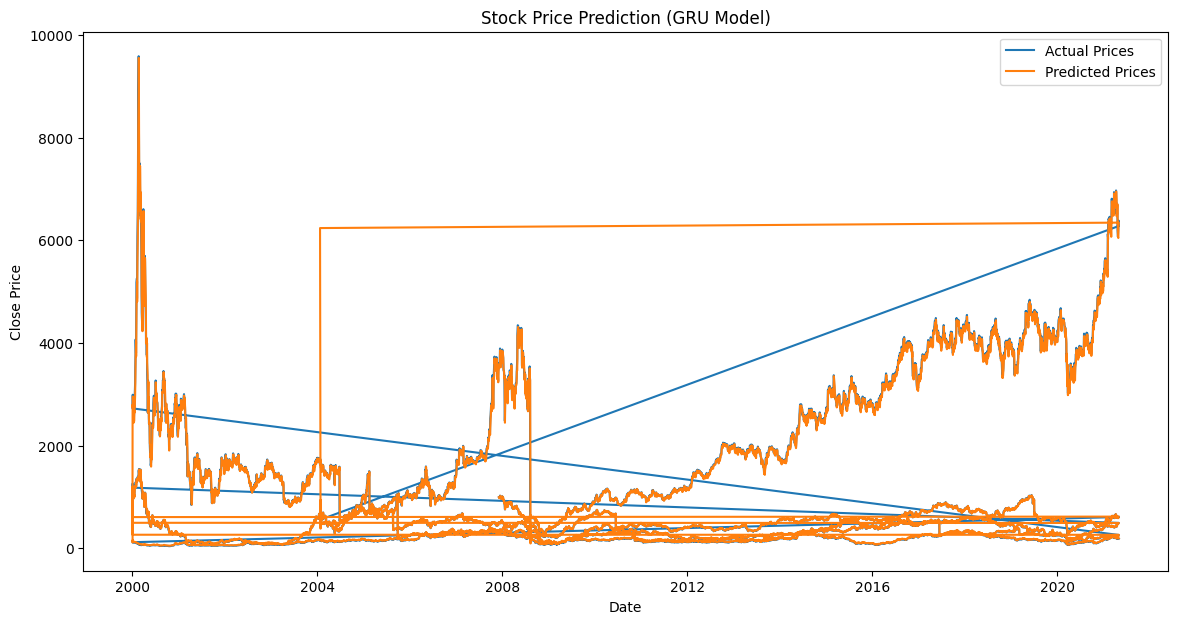

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from tensorflow.keras.callbacks import Callback
import requests
import io

warnings.filterwarnings("ignore")

# Custom callback to track metrics during training
class MetricsCallback(Callback):
    def __init__(self, x_val, y_val):
        self.x_val = x_val
        self.y_val = y_val
        self.epochs_accuracy = []
        self.epochs_f1 = []
        self.epochs_precision = []

    def on_epoch_end(self, epoch, logs=None):
        # Predict the results on the validation data
        y_pred = self.model.predict(self.x_val)
        y_pred = np.round(y_pred)  # Round the predictions to get class labels

        # Calculate accuracy, F1, and precision for the current epoch
        accuracy = accuracy_score(self.y_val, y_pred)
        f1 = f1_score(self.y_val, y_pred)
        precision = precision_score(self.y_val, y_pred)

        # Store the metrics
        self.epochs_accuracy.append(accuracy)
        self.epochs_f1.append(f1)
        self.epochs_precision.append(precision)

        # Print metrics for the current epoch
        print(f"Epoch {epoch+1} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Precision: {precision:.4f}")

def process_csv(file_url):
    # Download the file from GitHub
    response = requests.get(file_url)

    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(io.StringIO(response.text))
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    df = df[['Date', 'Open', 'Close']]

    # Calculate the stock movement (up or down)
    df['Price_Movement'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)  # 1 for up, 0 for down

    # Plot stock prices
    plt.figure(figsize=(14, 7))
    plt.plot(df['Date'], df['Close'], label="Stock Prices")
    plt.title(f"Stock Prices Over Time")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.savefig(f"StockPrice.jpg")
    print(f"Saved stock prices plot.")

    # Prepare data for GRU model
    dataset = df[['Close']].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)

    training_data_len = int(len(scaled_data) * 0.9)
    train_data = scaled_data[:training_data_len]
    test_data = scaled_data[training_data_len - 60:]

    # Create sequences for training and testing
    def create_sequences(data, seq_length):
        x, y = [], []
        for i in range(seq_length, len(data)):
            x.append(data[i - seq_length:i, 0])
            y.append(data[i, 0])
        return np.array(x), np.array(y)

    seq_length = 60
    x_train, y_train = create_sequences(train_data, seq_length)
    x_test, y_test = create_sequences(test_data, seq_length)

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # Build GRU model
    model = Sequential()
    model.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(GRU(units=50, return_sequences=False))
    model.add(Dense(units=25))
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Define the callback for tracking metrics
    metrics_callback = MetricsCallback(x_test, y_test)

    # Train the model with the custom callback
    model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_test, y_test), callbacks=[metrics_callback])

    # Predict using the trained model
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    # Compare with actual data
    y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    plt.figure(figsize=(14, 7))
    plt.plot(df['Date'][training_data_len:], y_test_scaled, label="Actual Prices")
    plt.plot(df['Date'][training_data_len:], predictions, label="Predicted Prices")
    plt.title(f"Stock Price Prediction (GRU Model)")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.savefig(f"PricePrediction_GRU.jpg")
    print(f"Saved price prediction plot for GRU.")

    # Calculate the total (average) metrics over all epochs
    total_accuracy = np.mean(metrics_callback.epochs_accuracy)
    total_f1 = np.mean(metrics_callback.epochs_f1)
    total_precision = np.mean(metrics_callback.epochs_precision)

    print(f"Total (Average) Metrics over all epochs:")
    print(f"Accuracy: {total_accuracy:.4f}")
    print(f"F1 Score: {total_f1:.4f}")
    print(f"Precision: {total_precision:.4f}")

    # Print model summary and return metrics
    model.summary()
    return total_accuracy, total_f1, total_precision

def process_folder(file_url):
    # Directly use the URL to read the Nifty_50_concatenated.csv file
    print(f"Processing file from URL: {file_url}")
    accuracy, f1, precision = process_csv(file_url)
    print(f"Total Accuracy: {accuracy:.4f}, Total F1 Score: {f1:.4f}, Total Precision: {precision:.4f}")

if __name__ == "__main__":
    file_url = "https://raw.githubusercontent.com/Silverstar2793/DM_Nifty/main/Nifty_50_concatenated.csv"
    process_folder(file_url)
